# 1. Data Observation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "E:/Hackathon/CabFarePrediction/"

In [3]:
train = pd.read_csv(path+'TRAIN.CSV')
test = pd.read_csv(path + 'TEST.CSV')

In [4]:
train.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare
0,0,1543203646318,Lyft,Boston University,Theatre District,3.03,1.0,Lux Black XL,34.0
1,1,1543203646319,Uber,South Station,Theatre District,1.30,1.0,Black,18.5
2,2,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberX,19.5
3,3,1543203646320,Lyft,Northeastern University,Beacon Hill,2.43,1.0,Lyft,10.5
4,4,1543203646320,Uber,Theatre District,Fenway,2.71,1.0,UberXL,32.0


In [5]:
train.shape, test.shape

((100000, 9), (25000, 8))

In [6]:
test.head()

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type
0,0,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lux
1,1,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lux Black XL
2,2,1543364124206,Uber,Financial District,Fenway,6.83,1.0,UberX
3,3,1543364124206,Uber,Beacon Hill,Haymarket Square,1.35,1.0,UberXL
4,4,1543364124206,Lyft,Theatre District,South Station,0.59,1.0,Lyft XL


In [7]:
train['cab_type'].value_counts()

Black           8744
Black SUV       8712
UberXL          8676
UberX           8588
WAV             8585
UberPool        8558
Lyft XL         8115
Lux Black XL    8065
Lux             8060
Shared          7998
Lyft            7957
Lux Black       7942
Name: cab_type, dtype: int64

In [8]:
train['cab_provider'].value_counts()

Uber    51863
Lyft    48137
Name: cab_provider, dtype: int64

In [9]:
train['distance'].max(), train['distance'].min()

(7.5, 0.02)

In [10]:
train['surge_multiplier'].value_counts()

1.00    96753
1.25     1715
1.50      764
1.75      403
2.00      337
2.50       23
3.00        5
Name: surge_multiplier, dtype: int64

The private rideshare service says it uses an algorithm based on classic supply and demand: When demand for cars goes up, prices go up to decrease demand and to encourage more drivers to get on the road, increasing supply.

` Price = Normal Price * Surge_multiplier `

# Exploratory Data Analaysis

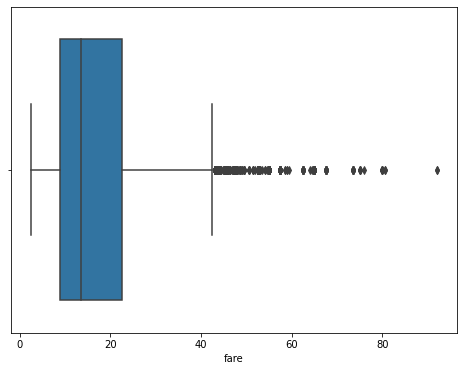

In [11]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'fare', data = train);

In [12]:
# Skew and kurt

print("Skewness: %f" % train['fare'].skew())
print("Kurtosis: %f" % train['fare'].kurt())

Skewness: 1.039652
Kurtosis: 1.149118


In [13]:
xtrain = train.copy()
xtest = test.copy()

In [14]:
# Let's apply Log(1+x) on Fare

xtrain['fare'] = np.log1p(xtrain['fare'])

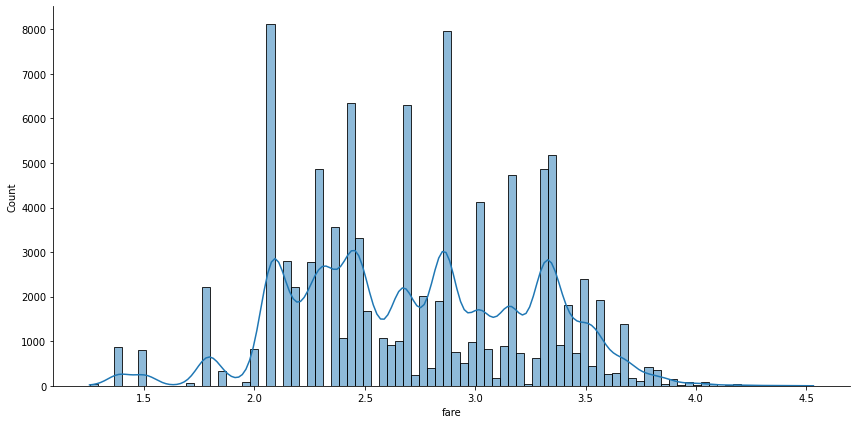

In [15]:
sns.displot(x = 'fare', data = xtrain, aspect = 2, height = 6, kde = True);

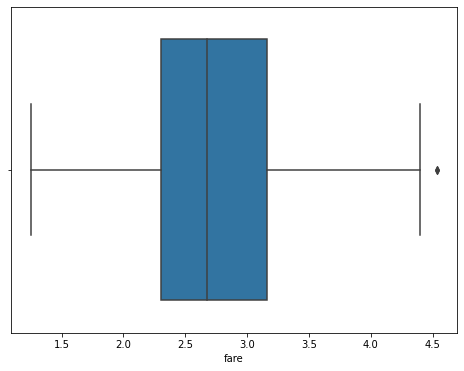

In [16]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'fare', data = xtrain);

## Independent Variable Analysis

### Extract Day Date and Time from TimeStamp

In [17]:
xtrain['date_time'] = pd.to_datetime(xtrain['time_stamp'] / 1000, unit = 's')

In [18]:
xtrain['hour'] = xtrain['date_time'].dt.hour

In [19]:
xtest['date_time'] = pd.to_datetime(xtest['time_stamp'] / 1000, unit = 's')

In [20]:
xtest['hour'] = xtest['date_time'].dt.hour

## Corrleation

Let's encode all the features and check the correlation

In [21]:
labeldf = xtrain.copy()

In [22]:
from sklearn import preprocessing

In [23]:
label_encoder = preprocessing.LabelEncoder()

In [24]:
for i in labeldf:
    if labeldf[i].dtypes == 'object':
        labeldf[i] = label_encoder.fit_transform(labeldf[i])

In [25]:
labeldf.head(4)

,index,time_stamp,cab_provider,source,destination,distance,surge_multiplier,cab_type,fare,date_time,hour
0,0,1543203646318,0,2,10,3.03,1.0,4,3.555348,2018-11-26 03:40:46.318000128,3
1,1,1543203646319,1,9,10,1.30,1.0,0,2.970414,2018-11-26 03:40:46.319000064,3
2,2,1543203646320,1,10,3,2.71,1.0,9,3.020425,2018-11-26 03:40:46.320000000,3
3,3,1543203646320,0,8,1,2.43,1.0,5,2.442347,2018-11-26 03:40:46.320000000,3


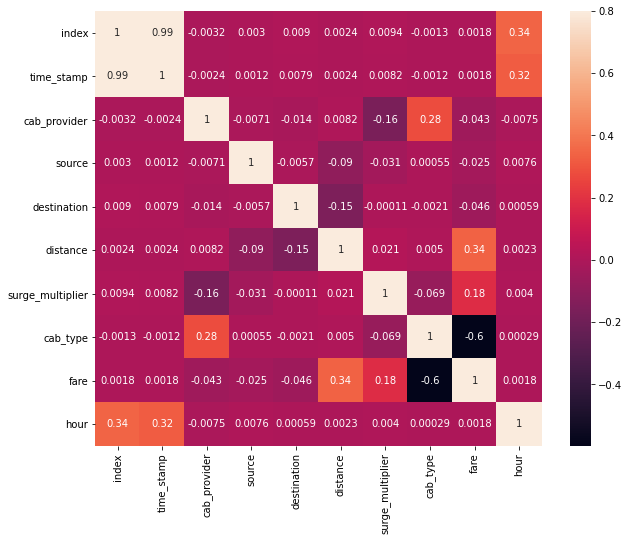

In [26]:
corrmat = labeldf.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corrmat, vmax = .8, annot = True);

In [27]:
xtrain.drop('index', inplace = True, axis =1)
xtrain.drop('time_stamp', inplace = True, axis = 1)
xtrain.drop('date_time', inplace = True, axis = 1)

In [28]:
xtest.drop('index', inplace = True, axis =1)
xtest.drop('time_stamp', inplace = True, axis = 1)
xtest.drop('date_time', inplace = True, axis = 1)

## Fix skewed Features

In [29]:
# Fetch all numerical features

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in xtrain.columns:
    if xtrain[i].dtype in numeric_dtypes:
        numeric.append(i)

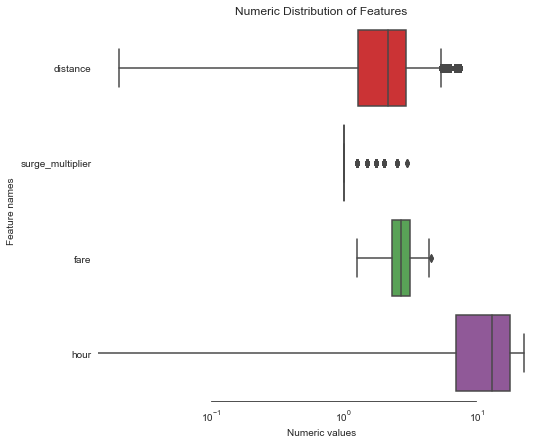

In [30]:
# Create box plots for all numeric features

sns.set_style('white')
f, ax = plt.subplots(figsize = (8,7))
ax.set_xscale('log')
ax = sns.boxplot(data = xtrain[numeric], orient = "h", palette = 'Set1')
ax.xaxis.grid(False)
ax.set(ylabel = "Feature names")
ax.set(xlabel = "Numeric values")
ax.set(title = "Numeric Distribution of Features")
sns.despine(trim = True, left = True)

### Balancing Dataset

In [31]:
# surge_multiplier

xtrain['surge_multiplier'].value_counts()

1.00    96753
1.25     1715
1.50      764
1.75      403
2.00      337
2.50       23
3.00        5
Name: surge_multiplier, dtype: int64

In [32]:
xfilter = xtrain[xtrain['surge_multiplier'] == 1.00][:2500]

In [33]:
xtrain = xtrain[xtrain['surge_multiplier'] != 1.00]

In [34]:
xtrain['surge_multiplier'].value_counts()

1.25    1715
1.50     764
1.75     403
2.00     337
2.50      23
3.00       5
Name: surge_multiplier, dtype: int64

In [35]:
xtrain = pd.concat([xtrain, xfilter])

In [36]:
xtrain['surge_multiplier'].value_counts()

1.00    2500
1.25    1715
1.50     764
1.75     403
2.00     337
2.50      23
3.00       5
Name: surge_multiplier, dtype: int64

In [37]:
xtrain = xtrain[xtrain['surge_multiplier'] != 3.00]
xtrain = xtrain[xtrain['surge_multiplier'] != 2.50]


In [38]:
xtrain['surge_multiplier'].value_counts()

1.00    2500
1.25    1715
1.50     764
1.75     403
2.00     337
Name: surge_multiplier, dtype: int64

In [39]:
xtrain.shape

(5719, 8)

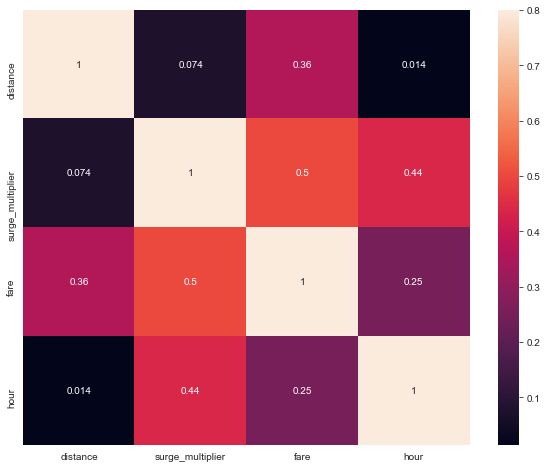

In [40]:
# Correlation


corrmat = xtrain.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corrmat, vmax = .8, annot = True);

In [41]:
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [42]:
# Find skewed numerical features

skew_features = xtrain[numeric].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew': high_skew})
skew_features.head(10)

There are 3 numerical features with Skew > 0.5 :


surge_multiplier    1.102396
hour                0.856791
distance            0.516078
fare               -0.118377
dtype: float64

In [43]:
xxtrain = xtrain.copy()

In [44]:
# Normalize skewed features

xxtrain["distance"] = boxcox1p(xxtrain["distance"], boxcox_normmax(xxtrain["distance"] + 1))
xxtrain["hour"] = boxcox1p(xxtrain["hour"], boxcox_normmax(xxtrain["hour"] + 1))

xtest['distance'] = boxcox1p(xtest['distance'], boxcox_normmax(xtest['distance'] + 1))
xtest['hour'] = boxcox1p(xtest['hour'], boxcox_normmax(xtest['hour'] + 1))

In [45]:
# Find skewed numerical features

skew_features = xxtrain[numeric].apply(lambda x: skew(x)).sort_values(ascending = False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew': high_skew})
skew_features.head(10)

There are 1 numerical features with Skew > 0.5 :


surge_multiplier    1.102396
distance            0.014082
hour               -0.006454
fare               -0.118377
dtype: float64

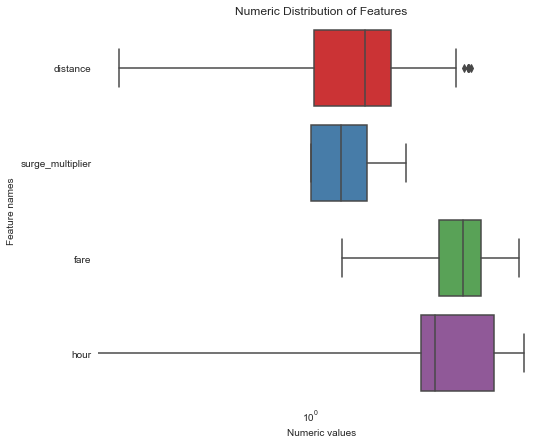

In [46]:
# Create box plots for all numeric features

sns.set_style('white')
f, ax = plt.subplots(figsize = (8,7))
ax.set_xscale('log')
ax = sns.boxplot(data = xxtrain[numeric], orient = "h", palette = 'Set1')
ax.xaxis.grid(False)
ax.set(ylabel = "Feature names")
ax.set(xlabel = "Numeric values")
ax.set(title = "Numeric Distribution of Features")
sns.despine(trim = True, left = True)

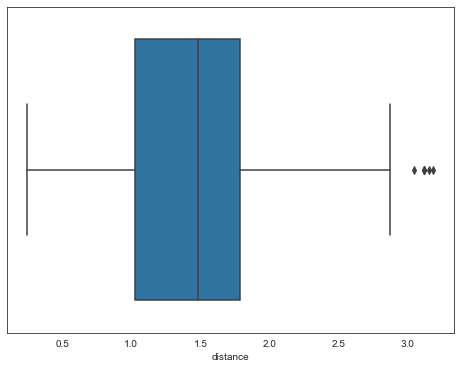

In [47]:
# Distance

plt.figure(figsize = (8,6))
sns.boxplot(x = 'distance', data = xxtrain);

## Encode Categorical Features

In [48]:
xxtrain = pd.get_dummies(xxtrain).reset_index(drop = True)
xtest = pd.get_dummies(xtest).reset_index(drop = True)

In [49]:
xxtrain

,distance,surge_multiplier,fare,hour,cab_provider_Lyft,cab_provider_Uber,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,...,cab_type_Lux,cab_type_Lux Black,cab_type_Lux Black XL,cab_type_Lyft,cab_type_Lyft XL,cab_type_Shared,cab_type_UberPool,cab_type_UberX,cab_type_UberXL,cab_type_WAV
0,2.323822,1.75,3.881564,1.635315,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2.323822,1.75,4.151040,1.635315,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,1.530202,1.25,3.020425,1.635315,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,1.168230,1.75,3.295837,1.635315,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.662334,1.25,3.157000,1.951272,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5714,1.998818,1.00,3.157000,2.672792,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5715,1.679421,1.00,3.449988,2.672792,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5716,1.679421,1.00,3.178054,2.672792,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5717,1.493700,1.00,2.708050,2.672792,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
xtest

,distance,surge_multiplier,hour,cab_provider_Lyft,cab_provider_Uber,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,...,cab_type_Lux,cab_type_Lux Black,cab_type_Lux Black XL,cab_type_Lyft,cab_type_Lyft XL,cab_type_Shared,cab_type_UberPool,cab_type_UberX,cab_type_UberXL,cab_type_WAV
0,0.481668,1.0,0.000000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.481668,1.0,0.000000,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2.444188,1.0,0.000000,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.916622,1.0,0.000000,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.481668,1.0,0.000000,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.570573,1.0,6109.768034,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24996,1.570573,1.0,6109.768034,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24997,1.570573,1.0,6109.768034,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,1.542412,1.0,6109.768034,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


# Models , Evaluation Metrics and Tuning

## Training and test sets

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [52]:
extrain = xxtrain.copy()
extrain = extrain.sample(frac = 1)
extrain = extrain.iloc[:25000]

In [53]:
X = extrain.drop('fare', axis = 1)
y = extrain['fare']

# test data

tX = xtest.copy()

In [54]:
scaler = StandardScaler()

**Scaling Training Data**

In [55]:
X

,distance,surge_multiplier,hour,cab_provider_Lyft,cab_provider_Uber,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,...,cab_type_Lux,cab_type_Lux Black,cab_type_Lux Black XL,cab_type_Lyft,cab_type_Lyft XL,cab_type_Shared,cab_type_UberPool,cab_type_UberX,cab_type_UberXL,cab_type_WAV
1294,1.210284,1.25,1.951272,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2285,1.879746,2.00,3.769450,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
100,1.326930,1.25,2.459737,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4087,2.162638,1.00,2.221856,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2785,1.103583,1.50,4.425609,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,1.236166,1.00,2.221856,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4680,1.236166,1.00,2.459737,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2685,1.875812,1.25,4.327257,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5125,1.840134,1.00,2.459737,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [56]:
X[['distance','hour']] = scaler.fit_transform(X[['distance','hour']])

In [57]:
X

,distance,surge_multiplier,hour,cab_provider_Lyft,cab_provider_Uber,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,...,cab_type_Lux,cab_type_Lux Black,cab_type_Lux Black XL,cab_type_Lyft,cab_type_Lyft XL,cab_type_Shared,cab_type_UberPool,cab_type_UberX,cab_type_UberXL,cab_type_WAV
1294,-0.376402,1.25,-0.873965,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2285,0.946687,2.00,0.873920,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
100,-0.145870,1.25,-0.385158,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4087,1.505780,1.00,-0.613842,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2785,-0.587281,1.50,1.504710,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,-0.325250,1.00,-0.613842,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4680,-0.325250,1.00,-0.385158,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2685,0.938913,1.25,1.410160,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5125,0.868401,1.00,-0.385158,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [58]:
scaler = StandardScaler()

**Scaling Testing Data**

In [59]:
tX

,distance,surge_multiplier,hour,cab_provider_Lyft,cab_provider_Uber,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,...,cab_type_Lux,cab_type_Lux Black,cab_type_Lux Black XL,cab_type_Lyft,cab_type_Lyft XL,cab_type_Shared,cab_type_UberPool,cab_type_UberX,cab_type_UberXL,cab_type_WAV
0,0.481668,1.0,0.000000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.481668,1.0,0.000000,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2.444188,1.0,0.000000,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.916622,1.0,0.000000,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.481668,1.0,0.000000,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.570573,1.0,6109.768034,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24996,1.570573,1.0,6109.768034,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24997,1.570573,1.0,6109.768034,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,1.542412,1.0,6109.768034,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [60]:
tX[['distance','hour']] = scaler.fit_transform(tX[['distance','hour']])

In [61]:
tX

,distance,surge_multiplier,hour,cab_provider_Lyft,cab_provider_Uber,source_Back Bay,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,...,cab_type_Lux,cab_type_Lux Black,cab_type_Lux Black XL,cab_type_Lyft,cab_type_Lyft XL,cab_type_Shared,cab_type_UberPool,cab_type_UberX,cab_type_UberXL,cab_type_WAV
0,-1.723543,1.0,-1.765259,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-1.723543,1.0,-1.765259,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2.919424,1.0,-1.765259,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,-0.694521,1.0,-1.765259,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-1.723543,1.0,-1.765259,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.852610,1.0,2.409603,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24996,0.852610,1.0,2.409603,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24997,0.852610,1.0,2.409603,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24998,0.785986,1.0,2.409603,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Setup cross validation and define error metrics

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [64]:
# Setup cross validation folds

kf = KFold(n_splits = 11, random_state = 42, shuffle = True)

In [65]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### Setup models

In [66]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


#### Linear Regression

In [67]:
model = LinearRegression()

In [68]:
model.fit(X_train, y_train)

LinearRegression()

In [69]:
print("Test R^2 Score: {:.5f}".format(model.score(X_test, y_test)))

Test R^2 Score: 0.96114


#### Light GBM

In [70]:
# Light Gradient Boosting Regressor

lightgbm = LGBMRegressor()

param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

gbm_grid = GridSearchCV(lightgbm, 
                   param_grid, 
                   cv = 2, 
                   n_jobs = 5,
                   verbose = True)
gbm_grid.fit(X_train, y_train)

Fitting 2 folds for each of 2916 candidates, totalling 5832 fits


GridSearchCV(cv=2, estimator=LGBMRegressor(), n_jobs=5,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'max_depth': [15, 20, 25],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [400, 700, 1000],
                         'num_leaves': [50, 100, 200],
                         'reg_alpha': [1.1, 1.2, 1.3],
                         'reg_lambda': [1.1, 1.2, 1.3],
                         'subsample': [0.7, 0.8, 0.9], 'subsample_freq': [20]},
             verbose=True)

In [71]:
print(gbm_grid.best_score_)

0.959120045967707


In [72]:
print(gbm_grid.best_params_)

{'colsample_bytree': 0.8, 'max_depth': 15, 'min_split_gain': 0.3, 'n_estimators': 400, 'num_leaves': 50, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.9, 'subsample_freq': 20}


In [73]:
lgbm_params = {'colsample_bytree': 0.7, 
          'max_depth': 15, 
          'min_split_gain': 0.3, 
          'n_estimators': 400, 
          'num_leaves': 50, 
          'reg_alpha': 1.1, 
          'reg_lambda': 1.1, 
          'subsample': 0.9, 
          'subsample_freq': 20}

lightgbm = LGBMRegressor(**lgbm_params)

#### XGBoost

In [74]:
from xgboost import XGBRegressor

In [75]:
# XGBoost Regressor
xgboost = XGBRegressor()

param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgboost, 
                   param_grid, 
                   cv = 2, 
                   n_jobs = 5, 
                   verbose = True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[15:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [76]:
print(xgb_grid.best_score_)

0.971800010912125


In [77]:
print(xgb_grid.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [1]:
xgb_params = {'colsample_bytree': 0.7, 
             'learning_rate': 0.03, 
             'max_depth': 5, 
             'min_child_weight': 4, 
             'n_estimators': 500, 
             'nthread': 4, 
             'objective': 'reg:linear', 
             'silent': 1, 
             'subsample': 0.7}

xgboost = XGBRegressor(**xgb_params)

NameError: name 'XGBRegressor' is not defined

### Ridge Regressor

In [79]:
# Ridge Regressor
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

ridge_reg = Ridge()

ridge_grid = GridSearchCV(ridge_reg, 
                     param_grid = dict(alpha= alphas), 
                     cv = 2, 
                     n_jobs = 5, 
                     verbose = True)

ridge_grid.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


GridSearchCV(cv=2, estimator=Ridge(), n_jobs=5,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             verbose=True)

In [80]:
print(ridge_grid.best_score_)

0.9635137460605931


In [81]:
print(ridge_grid.best_params_)

{'alpha': 0.0001}


In [82]:
ridge_params = {'alpha': 0.0001}

ridge = Ridge(**ridge_params)

### Support Vector Regressor

In [83]:
# SVR

param_grid={
    
        'C': [0.1, 1, 100, 1000],
        
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        
    }
    

svr = SVR(kernel = 'rbf')

svr_grid = GridSearchCV(svr,
                      param_grid,
                      cv = 2, 
                      scoring = 'neg_mean_squared_error',
                      verbose = True, 
                      n_jobs = -1)

svr_grid.fit(X_train, y_train)

Fitting 2 folds for each of 308 candidates, totalling 616 fits


GridSearchCV(cv=2, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100, 1000],
                         'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                     0.1, 0.5, 1, 5, 10],
                         'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]},
             scoring='neg_mean_squared_error', verbose=True)

In [84]:
print(svr_grid.best_score_)

-0.009438031095030929


In [85]:
print(svr_grid.best_params_)

{'C': 100, 'epsilon': 0.05, 'gamma': 0.005}


In [86]:
svr_params = {'C': 100, 'epsilon': 0.05, 'gamma': 0.005}

In [87]:
svr = SVR(**svr_params)

### Gradient Boosting Regressor

In [88]:
# GBR

params = {
    'loss': ['ls', 'lad','huber','quantile'],
    'learning_rate': [0.1, 0.2,0.3],
    'max_depth': [3,5,6]
} 

gbr_model = GradientBoostingRegressor()

gbr_grid = GridSearchCV(gbr_model,
                  params,
                  cv = 2,
                  verbose = True,
                  n_jobs = 5)

gbr_grid.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'loss': ['ls', 'lad', 'huber', 'quantile'],
                         'max_depth': [3, 5, 6]},
             verbose=True)

In [89]:
print(gbr_grid.best_score_)

0.9692264832750632


In [90]:
print(gbr_grid.best_params_)

{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5}


In [91]:
gbr_params = {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5}

gbr = GradientBoostingRegressor(**gbr_params)

**GBR with balanced dataset**

- R2 Score: 0.9704435818146127
- Mean Squarred Error: 0.009362925635660182
- RMSE: 0.09676221181670137
- Mean Absolute Error : 0.06750763991137315

## RandomForest

In [92]:
### RandomForestRegressor

# Random Forest Regressor

para_grids = {
            "n_estimators" : [10,50,100],
            "max_features" : ["auto", "log2", "sqrt"],
            "min_samples_split":[2,4,8],
            "bootstrap"    : [True, False]
        }

rf = RandomForestRegressor()

rf_cv = GridSearchCV(rf,
                    para_grids,
                    n_jobs = 5,
                    cv = 2)

rf_cv.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=5,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 50, 100]})

In [93]:
print(rf_cv.best_score_)

0.9664115367602836


In [94]:
print(rf_cv.best_params_)

{'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 100}


In [95]:
rf_params = {'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 50}

In [96]:
rf = RandomForestRegressor(**rf_params)

### StackingCVRegressor

In [97]:
# 
stack_gen = StackingCVRegressor(regressors = (xgboost, 
                                              lightgbm, 
                                              svr, 
                                              ridge, 
                                              gbr, 
                                              rf),
                               meta_regressor = xgboost,
                               use_features_in_secondary = True)

## Train Models

In [98]:
scores = {}

score = cv_rmse(lightgbm)
print("lightgmb: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgmb: 0.1045 (0.0039)


In [99]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[15:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

In [100]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.0952 (0.0048)


In [101]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1085 (0.0033)


In [102]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.0998 (0.0042)


In [103]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.0958 (0.0048)


### Fit the models

In [104]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

stack_gen
[15:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to X

In [105]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

lightgbm


In [106]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

xgboost
[15:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [107]:
print('Svr')
svr_model_full_data = svr.fit(X, y)

Svr


In [108]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

Ridge


In [109]:
print('RandomForest')
rf_model_full_data = rf.fit(X, y)

RandomForest


In [110]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

GradientBoosting


### Blend models and get Predictions

In [111]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [112]:
# Get final precitions from the blended model
blended_score = rmsle(y, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.08244721991970726


**Blended Predictions:** (Attempt 1)

- RMSLE score on train data: 0.08116570706030446

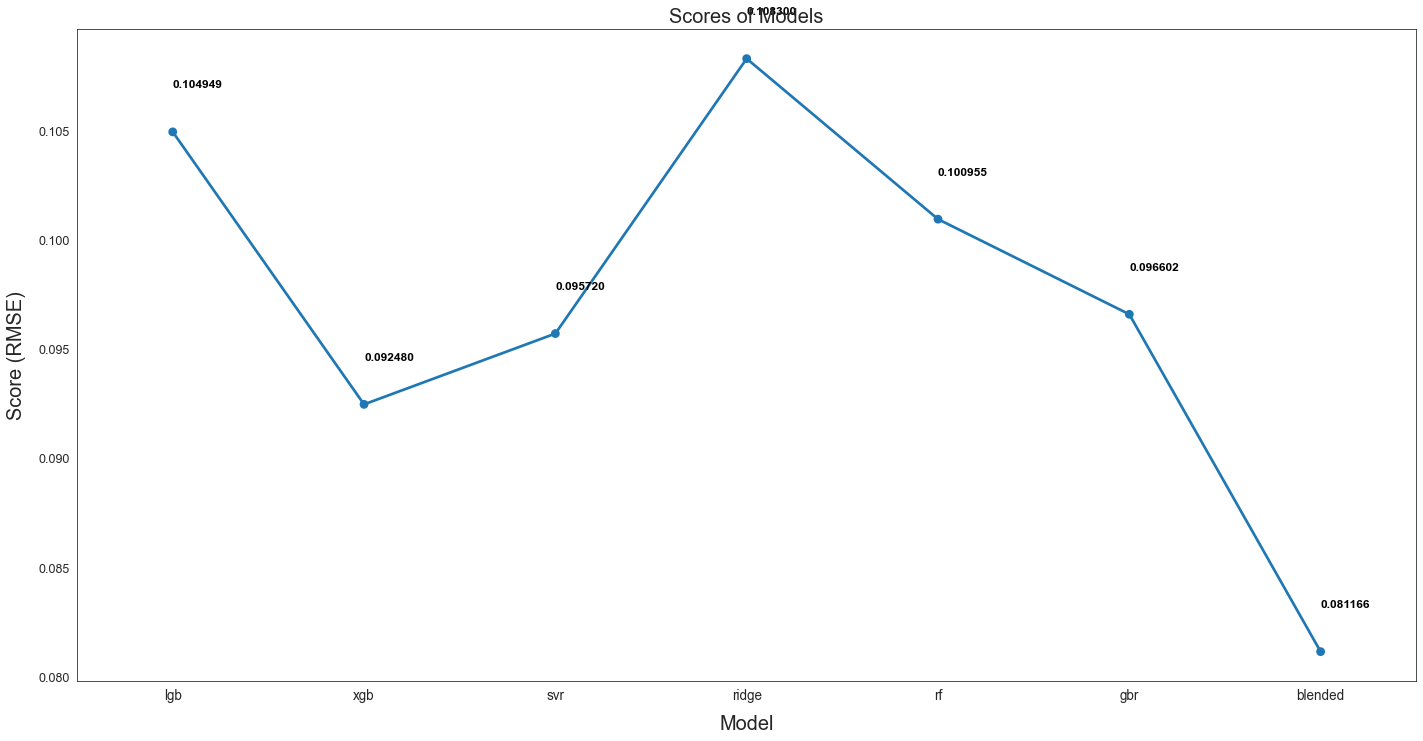

In [163]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

### Neural Network

In [90]:
X_train.shape

(4575, 41)

In [138]:

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from wandb.keras import WandbCallback

# Initialising the NN

model = Sequential()

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])


model = Sequential()
model.add(Dense(50, input_dim=378, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

Compile model
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adadelta())

model.fit(X_train, y_train, epochs=20, batch_size=10, verbose=0)

In [130]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_train = model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.0920322863060501
0.1257858337706249


In [132]:
r2_score(y_test, nn_pred)

0.9636443601597512

print(cross_val_score(model, X_train, y_train, cv = 3))

In [268]:
print("R2 Score:", r2_score(y_test, nn_pred))
print("Mean Squarred Error:", mean_squared_error(y_test, nn_pred))
print("RMSE:", math.sqrt(mean_squared_error(y_test, nn_pred)))
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,nn_pred)))

R2 Score: 0.9704370713710249
Mean Squarred Error: 0.009364988023557952
RMSE: 0.09677286822016774
Mean Absolute Error : 0.06752220095216618


In [189]:
## Submit predictions

submission = pd.read_csv('sample_submission.csv')

In [190]:
submission

,index,fare
0,0,11.0
1,1,26.0
2,2,18.5
3,3,11.5
4,4,9.0
5,5,10.5
6,6,7.0
7,7,7.0
8,8,26.0
9,9,5.0


In [113]:
output = pd.DataFrame(columns = ['index','fare'])

In [114]:
output['index'] = test.index

In [115]:
output['index'] = output['index'].astype('str')

In [116]:
output['fare'] = np.floor(np.expm1(blended_predictions(tX)))

In [117]:
output

,index,fare
0,0,11.0
1,1,26.0
2,2,14.0
3,3,12.0
4,4,10.0
...,...,...
24995,24995,9.0
24996,24996,10.0
24997,24997,33.0
24998,24998,7.0


In [120]:
# Fix outlier predictions

q1 = output['fare'].quantile(0.0045)
q2 = output['fare'].quantile(0.99)
output['fare'] = output['fare'].apply(lambda x: x if x > q1 else x * 0.77)
output['fare'] = output['fare'].apply(lambda x: x if x < q2 else x * 1.1)



In [121]:
output

,index,fare
0,0,11.0
1,1,26.0
2,2,14.0
3,3,12.0
4,4,10.0
...,...,...
24995,24995,9.0
24996,24996,10.0
24997,24997,33.0
24998,24998,7.0


In [122]:
output.to_csv("submission_regression.csv", index = False)

In [262]:
output

,index,fare
0,0,12.1
1,1,28.6
2,2,15.4
3,3,13.2
4,4,11.0
...,...,...
24995,24995,9.9
24996,24996,11.0
24997,24997,36.3
24998,24998,7.7


In [263]:
output.to_csv('custom_output.csv', index = False)

In [264]:
one83 = pd.read_csv('1dot83rmse.csv')

In [265]:
one83

,index,fare
0,0,11.017809
1,1,26.042094
2,2,14.022666
3,3,12.019428
4,4,10.016190
...,...,...
24995,24995,10.016190
24996,24996,10.016190
24997,24997,33.053427
24998,24998,7.011333
